In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset (train & val), alongside our given test data

This Task is task 2 (SEB VS NEVUS AND MEL). PLEASE USE APPROPRIATE PATH TO TASK
2

In [3]:
#please set title for saving model correctly!!!
title = "seb_vs_nev&mel_with_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

Initiliazing ViT Model

In [7]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 19s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
# Add additional layers after the Vision Transformer

model = tensorflow.keras.Sequential([
    vit_model,
    Flatten(),
    Dense(128, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(32, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(2, activation='softmax')
], name='vision_transformer')



model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 layer_normalization (LayerN  (None, 128)              256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

#function for focal loss
def focal_loss(gamma=2.0, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# compiling model using focal loss and adam optimizer
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',patience=4)       #configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                         #configuring initial learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

Plotting graph for Training and validation accuracy and loss

In [11]:
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()



    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)     #classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted') #calculating precision

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_augumented/task2"
test_dir = "/content/drive/MyDrive/msc_project/test/task2"

In [14]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [15]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=False, random_state=None)

In [16]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.8448
Epoch 1: val_accuracy improved from -inf to 0.90833, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_aug/model_fold_1.hdf5
96/96 [==============================] - 1018s 10s/step - loss: 0.0520 - accuracy: 0.8448 - val_loss: 0.0251 - val_accuracy: 0.9083 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.8740
Epoch 2: val_accuracy improved from 0.90833 to 0.91667, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_aug/model_fold_1.hdf5
96/96 [==================

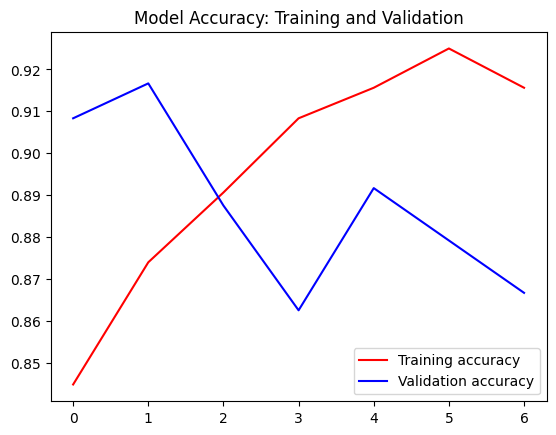

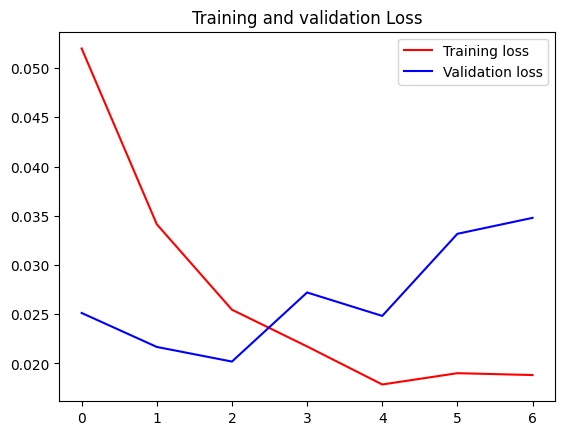

<Figure size 640x480 with 0 Axes>

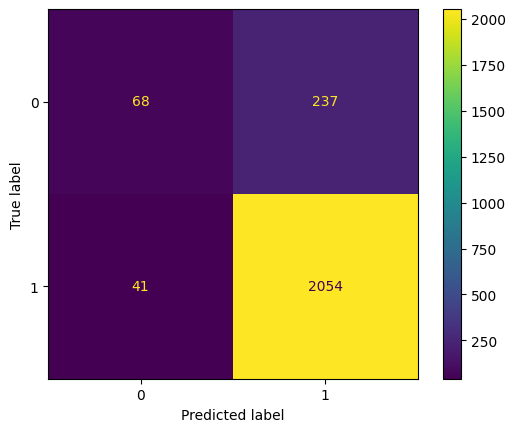


               precision    recall  f1-score   support

           0       0.62      0.22      0.33       305
           1       0.90      0.98      0.94      2095

    accuracy                           0.88      2400
   macro avg       0.76      0.60      0.63      2400
weighted avg       0.86      0.88      0.86      2400

Sensitivity: 0.98 Specificity: 0.223 Precision: 0.862 ROC_AUC_SCORE: 0.892



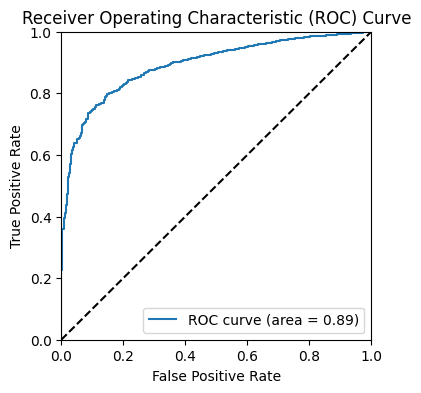

Validation complete...
Traning for Fold: 2
Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.8802
Epoch 1: val_accuracy improved from -inf to 0.90833, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_aug/model_fold_2.hdf5
96/96 [==============================] - 422s 4s/step - loss: 0.0294 - accuracy: 0.8802 - val_loss: 0.0213 - val_accuracy: 0.9083 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9094
Epoch 2: val_accuracy improved from 0.90833 to 0.92500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_aug/model_fold_2.hdf5
96/9

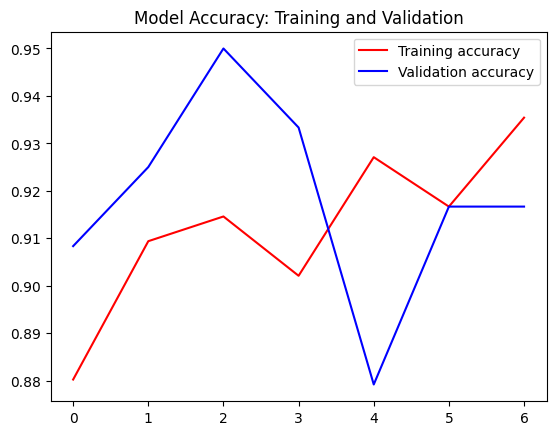

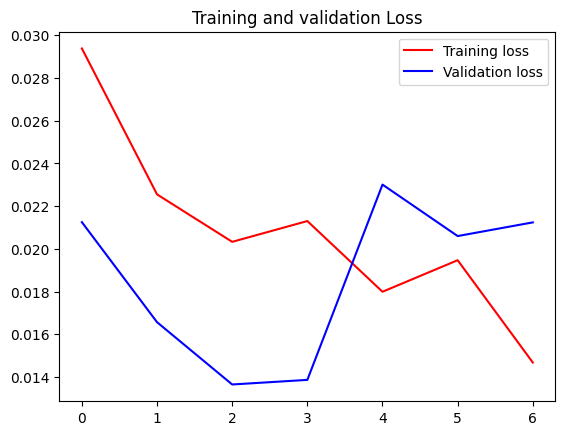

<Figure size 640x480 with 0 Axes>

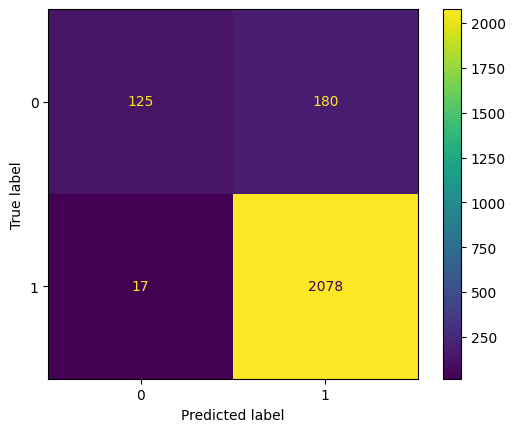


               precision    recall  f1-score   support

           0       0.88      0.41      0.56       305
           1       0.92      0.99      0.95      2095

    accuracy                           0.92      2400
   macro avg       0.90      0.70      0.76      2400
weighted avg       0.92      0.92      0.90      2400

Sensitivity: 0.992 Specificity: 0.41 Precision: 0.915 ROC_AUC_SCORE: 0.946



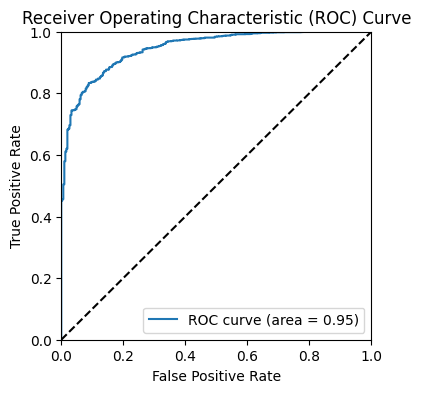

Validation complete...
Traning for Fold: 3
Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9156
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_aug/model_fold_3.hdf5
96/96 [==============================] - 209s 2s/step - loss: 0.0213 - accuracy: 0.9156 - val_loss: 0.0211 - val_accuracy: 0.9375 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9323
Epoch 2: val_accuracy did not improve from 0.93750
96/96 [==============================] - 130s 1s/step - loss: 0.0171 - accuracy: 0.9323 - val_loss: 0.0154 -

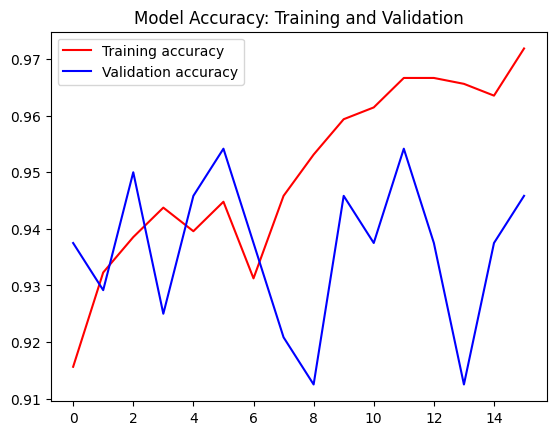

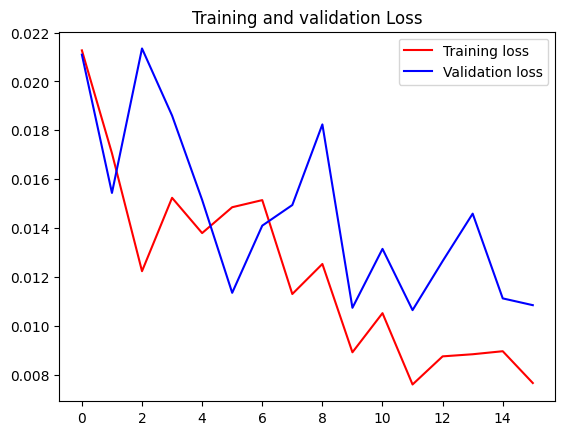

<Figure size 640x480 with 0 Axes>

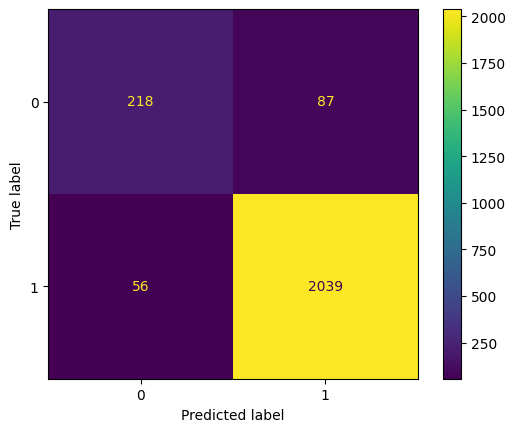


               precision    recall  f1-score   support

           0       0.80      0.71      0.75       305
           1       0.96      0.97      0.97      2095

    accuracy                           0.94      2400
   macro avg       0.88      0.84      0.86      2400
weighted avg       0.94      0.94      0.94      2400

Sensitivity: 0.973 Specificity: 0.715 Precision: 0.938 ROC_AUC_SCORE: 0.97



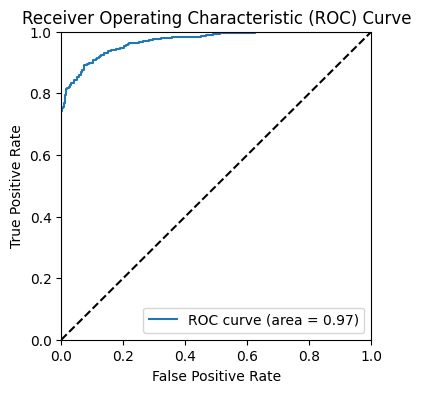

Validation complete...
Traning for Fold: 4
Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9333
Epoch 1: val_accuracy improved from -inf to 0.97083, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_aug/model_fold_4.hdf5
96/96 [==============================] - 113s 645ms/step - loss: 0.0156 - accuracy: 0.9333 - val_loss: 0.0084 - val_accuracy: 0.9708 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9375
Epoch 2: val_accuracy did not improve from 0.97083
96/96 [==============================] - 68s 707ms/step - loss: 0.0122 - accuracy: 0.9375 - val_loss: 0.0

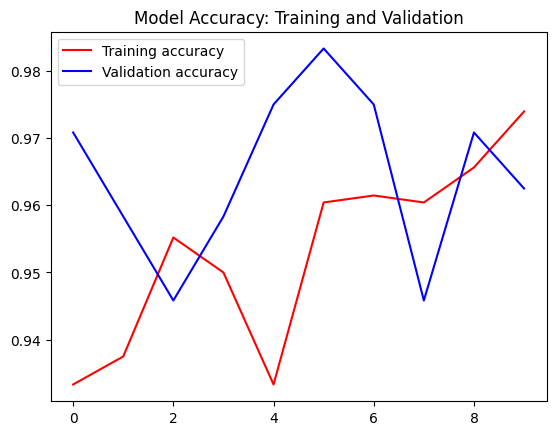

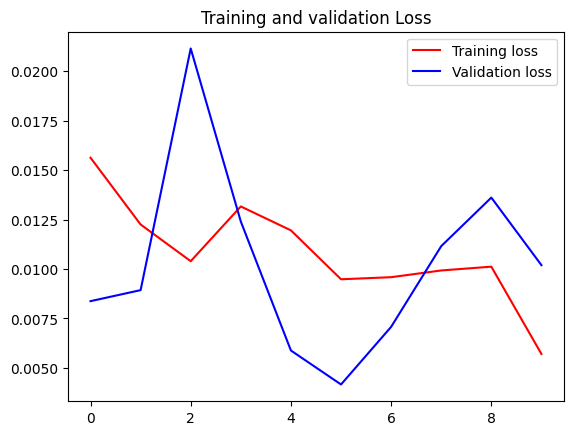

<Figure size 640x480 with 0 Axes>

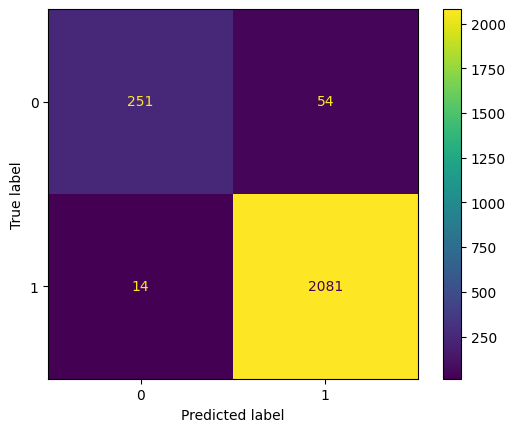


               precision    recall  f1-score   support

           0       0.95      0.82      0.88       305
           1       0.97      0.99      0.98      2095

    accuracy                           0.97      2400
   macro avg       0.96      0.91      0.93      2400
weighted avg       0.97      0.97      0.97      2400

Sensitivity: 0.993 Specificity: 0.823 Precision: 0.971 ROC_AUC_SCORE: 0.988



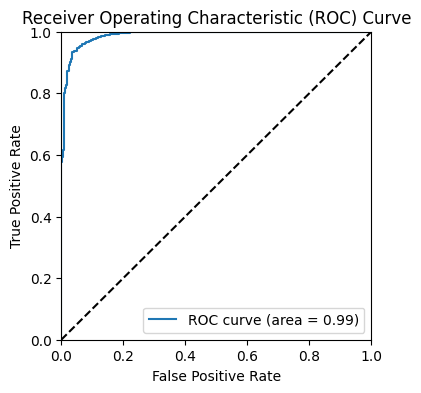

Validation complete...
Traning for Fold: 5
Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9510
Epoch 1: val_accuracy improved from -inf to 0.95833, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_aug/model_fold_5.hdf5
96/96 [==============================] - 107s 589ms/step - loss: 0.0119 - accuracy: 0.9510 - val_loss: 0.0098 - val_accuracy: 0.9583 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9698
Epoch 2: val_accuracy improved from 0.95833 to 0.97083, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_aug/model_fold_5.hdf5
9

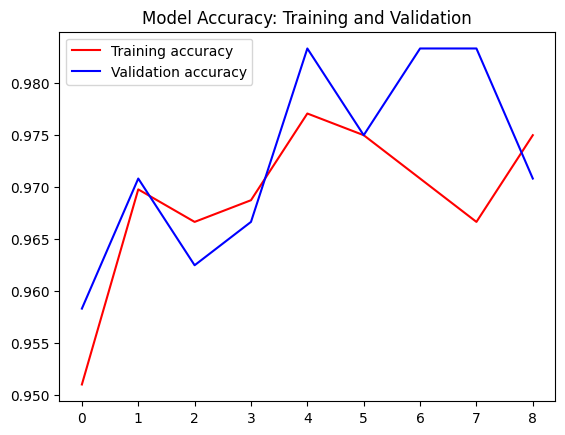

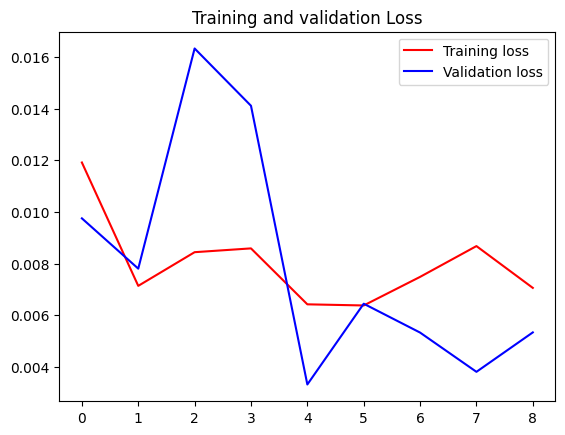

<Figure size 640x480 with 0 Axes>

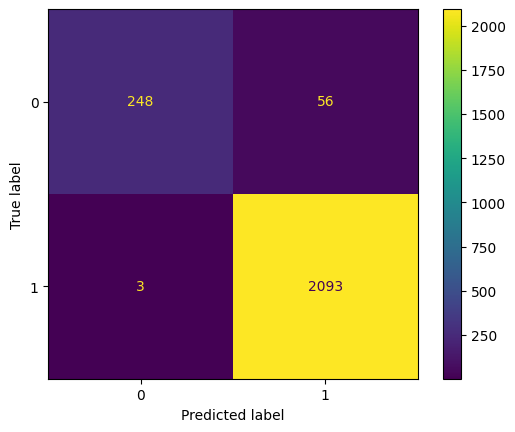


               precision    recall  f1-score   support

           0       0.99      0.82      0.89       304
           1       0.97      1.00      0.99      2096

    accuracy                           0.98      2400
   macro avg       0.98      0.91      0.94      2400
weighted avg       0.98      0.98      0.97      2400

Sensitivity: 0.999 Specificity: 0.816 Precision: 0.976 ROC_AUC_SCORE: 0.994



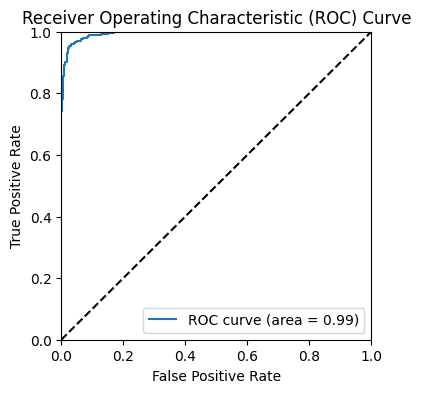

Validation complete...


In [17]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #please set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(
        optimizer='adam',
        loss=focal_loss(),
        metrics=['accuracy']
    )

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    #plotting graph of train and validation accuracy
    graph_it(history)

    # Evaluate the model on the test data
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


In [18]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

Found 600 images belonging to 2 classes.


Test using model 1
600/600 [==============================] - 99s 165ms/step


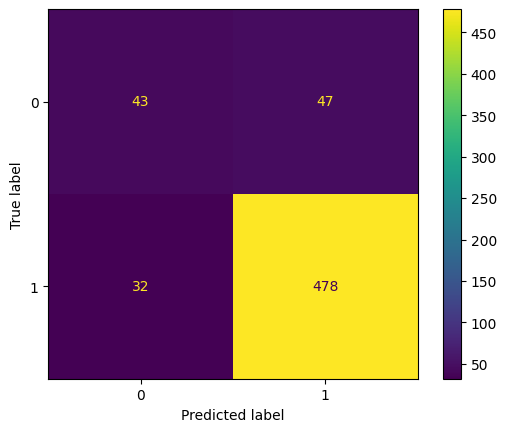


               precision    recall  f1-score   support

           0       0.57      0.48      0.52        90
           1       0.91      0.94      0.92       510

    accuracy                           0.87       600
   macro avg       0.74      0.71      0.72       600
weighted avg       0.86      0.87      0.86       600

Sensitivity: 0.937 Specificity: 0.478 Precision: 0.86 ROC_AUC_SCORE: 0.84



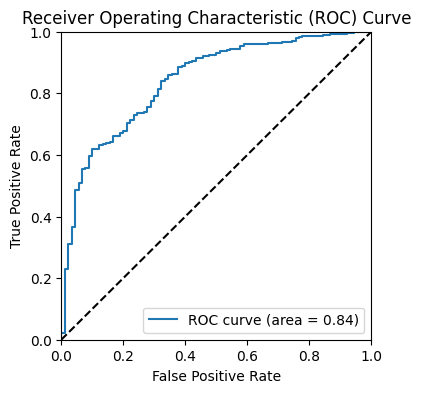

Testing Complete
Test using model 2
600/600 [==============================] - 26s 42ms/step


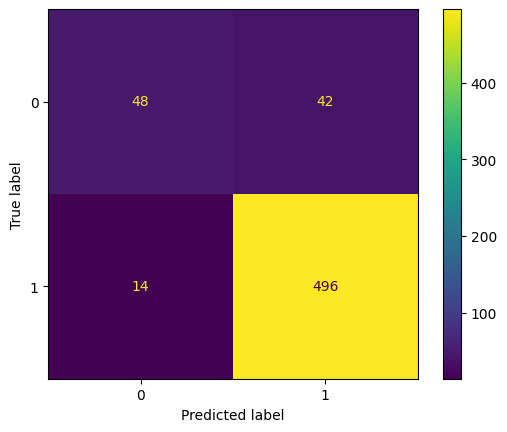


               precision    recall  f1-score   support

           0       0.77      0.53      0.63        90
           1       0.92      0.97      0.95       510

    accuracy                           0.91       600
   macro avg       0.85      0.75      0.79       600
weighted avg       0.90      0.91      0.90       600

Sensitivity: 0.973 Specificity: 0.533 Precision: 0.9 ROC_AUC_SCORE: 0.912



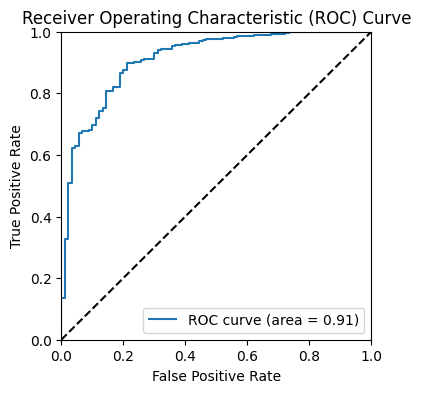

Testing Complete
Test using model 3
600/600 [==============================] - 26s 43ms/step


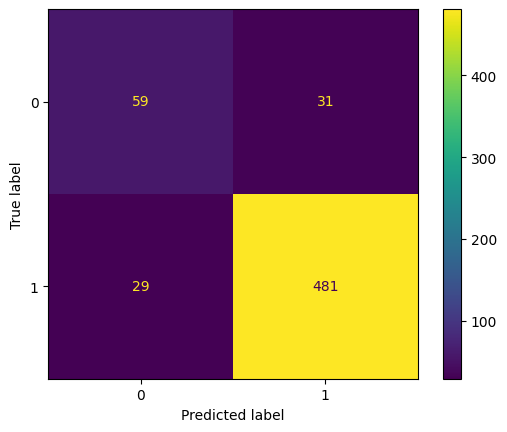


               precision    recall  f1-score   support

           0       0.67      0.66      0.66        90
           1       0.94      0.94      0.94       510

    accuracy                           0.90       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.90      0.90      0.90       600

Sensitivity: 0.943 Specificity: 0.656 Precision: 0.899 ROC_AUC_SCORE: 0.921



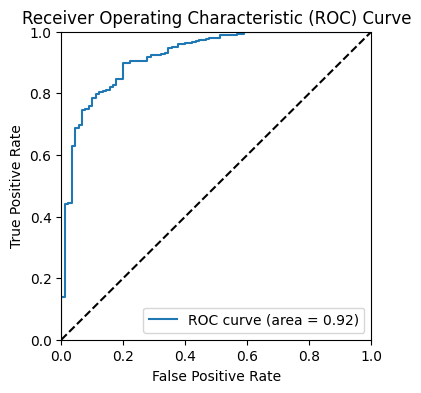

Testing Complete
Test using model 4
600/600 [==============================] - 26s 43ms/step


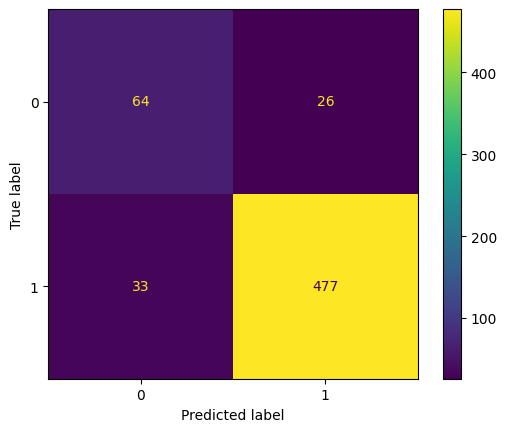


               precision    recall  f1-score   support

           0       0.66      0.71      0.68        90
           1       0.95      0.94      0.94       510

    accuracy                           0.90       600
   macro avg       0.80      0.82      0.81       600
weighted avg       0.91      0.90      0.90       600

Sensitivity: 0.935 Specificity: 0.711 Precision: 0.905 ROC_AUC_SCORE: 0.935



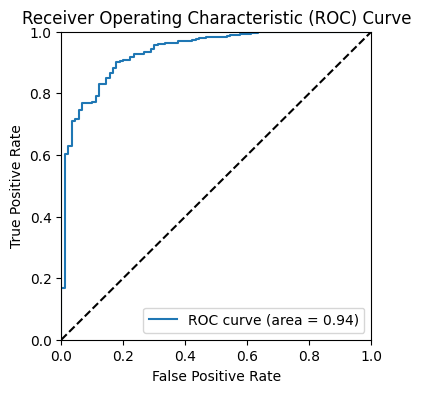

Testing Complete
Test using model 5
600/600 [==============================] - 28s 46ms/step


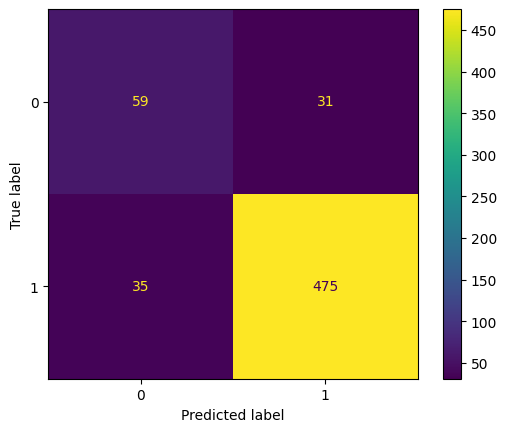


               precision    recall  f1-score   support

           0       0.63      0.66      0.64        90
           1       0.94      0.93      0.94       510

    accuracy                           0.89       600
   macro avg       0.78      0.79      0.79       600
weighted avg       0.89      0.89      0.89       600

Sensitivity: 0.931 Specificity: 0.656 Precision: 0.892 ROC_AUC_SCORE: 0.926



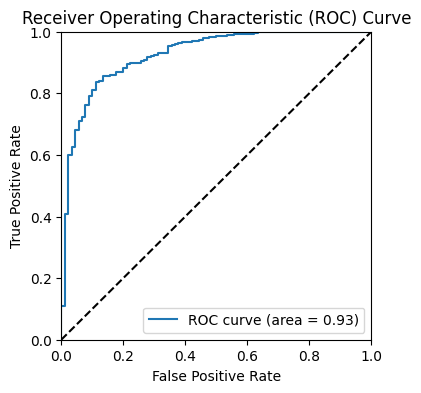

Testing Complete


In [19]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")